## Quantifying Influence of The Beatle and The Rolling Stones<br><br>
### With the data exported from the MusicBrainz database, which is further cleaned and aggregated in [this](Quantifying_Influence_Acquire_Clean_Merge.ipynb) notebook, I have refined the set of observations around the songs recorded and released by two artists. The response by which I will measure their influence is measured by other artists recorded use of their songs, "cover versions" or "covers" in the vernacular. This response is the **"times_covered"**<br><br>

### I also acquired the lyrics for as many of the original songs as I could using Beautiful Soup to scrape the lyrics from (lyrics.wikia.com)[http://lyrics.wikia.com). I was able to acquire lyrical content for 96.5% of the original songs to apply sentiment analysis using TextBlob. The sentiment polarity was applied separately to both the song title and the lyrics themselves to create features to augment the song/release data. As I am able to show below, the **lyric sentiment** is one of the more predictive measurements, second only to the year a song was released.<br><br>

### With each row in my dataset - songname, artist, etc., I then merged the number of times the song was covered ("times_covered") and the number of artists covering the song ("artist_cnt"). I also created a binary response (**"is_covered"**) as a simpler indicator that the song was used over the number of times used. This proved to be more predictable than the number of times covered. Also included is the average rating of the cover versions per song though I suspect the data is not so useful.

In [1]:
### Import as many items as possible to have available.
### Import data from CSV

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import MultinomialNB

data = pd.read_csv('data/Influence_clean.csv', header=0,encoding= 'utf-8',  delimiter='|')
data['minreleasedate'] = pd.to_datetime(pd.Series(data.minreleasedate))
data['times_covered'].fillna(0, inplace=True)
data['artistid'] = data.artist.map({'The Beatles':0, 'The Rolling Stones':1})

In [2]:
data['artist'] = data.artist.astype('category')
data['songname'] = data.songname.astype('category')
# Add column for year of release for simpler grouping.
data['year'] = data['minreleasedate'].apply(lambda x: x.year)

# Make binary response - song has been covered or not. Far better accuracy over "times covered".
data['is_covered'] = data.times_covered.map(lambda x: 1 if x > 0 else 0)


## Check coverage of lyrics for the original songs.
### **96.6%** have lyrics (and lyric sentiment polarity score) in the dataset. **Lyric sentiment** is a valuable predictor.

In [3]:
data[(data.is_cover == 0) & (data.lyrics.isnull())].workid.count().astype(float)/data[(data.is_cover == 0)].workid.count()

0.033457249070631967

### Create base set of features for fitting to models

In [4]:
feature_cols = [ 'year','num_releases','lyric_sent','title_sent', 'countries', 'avg_rating']
X= data[data.is_cover == 0][feature_cols]
y = data[data.is_cover == 0].is_covered
y_regress = data[data.is_cover == 0].times_covered
print X.shape
print y.shape
print y_regress.shape

(269, 6)
(269,)
(269,)


## Build model with Random Forest Classifier (RFC)

In [5]:
feature_range = range(1, len(feature_cols)+1)

# list to store the accuracy score for each value of max_features
Acc_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfclass = RandomForestClassifier(n_estimators=500, max_features=feature, random_state=50)
    acc_val_scores = cross_val_score(rfclass, X, y, cv=10, scoring='accuracy')
    Acc_scores.append(acc_val_scores.mean())

### I have chosen 6 features for the RFC model after running a looped evaluation of the maximum features for the model using cross validation.

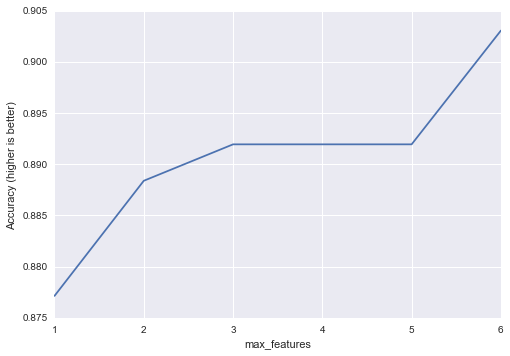

In [6]:
# plot max_features (x-axis) versus Accuracy score (y-axis)
plt.plot(feature_range, Acc_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy (higher is better)')

In [7]:
rfclass = RandomForestClassifier(n_estimators=175,  max_features=6,oob_score=True, random_state=50)
rfclass.fit(X, y)
print rfclass.oob_score_
print cross_val_score(rfclass, X, y, cv=10, scoring='accuracy').mean()

0.921933085502
0.903347578348


### At *92%* and *90%* respectively, both the out of bag and cross-validation scores are quite positive for the Random Forest Classifier. 


### Testing Random Forest Regressor to predict "times_covered"

In [8]:
from sklearn.feature_selection import SelectFromModel
rfreg = RandomForestRegressor(n_estimators=100, max_features=6, random_state=111)
rfreg.fit(X,y_regress)
sfm = SelectFromModel(rfreg, threshold='mean', prefit=True)
X_important = sfm.transform(X)
print(X_important.shape[0],X_important.shape[1])

(269, 4)


In [9]:
rfreg = RandomForestRegressor(n_estimators=100, max_features=3, random_state=111)
scores = cross_val_score(rfreg, X_important, y_regress, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

28.102616089590231

### I conclude that I can predict whether a song will be covered far more accurately than how many times it will be covered.<br>
**90%** vs. **28%**
<br><br>


## Test with DecisionTreeClassifier
### While seeking a less opaque model than the Random Forest, I tried the DecisionTreeClassifier, to take advantage of the very nice method for ranking the importance of the features.

In [10]:
treeclf = DecisionTreeClassifier(max_depth = 15, random_state=123)
treeclf.fit(X, y)
scores = cross_val_score(treeclf, X, y, cv=10).mean()
np.mean(np.sqrt(scores))

0.94857603796242917

### As shown in the bar chart below, year and lyric sentiment are better predictors of whether or not a song is covered.

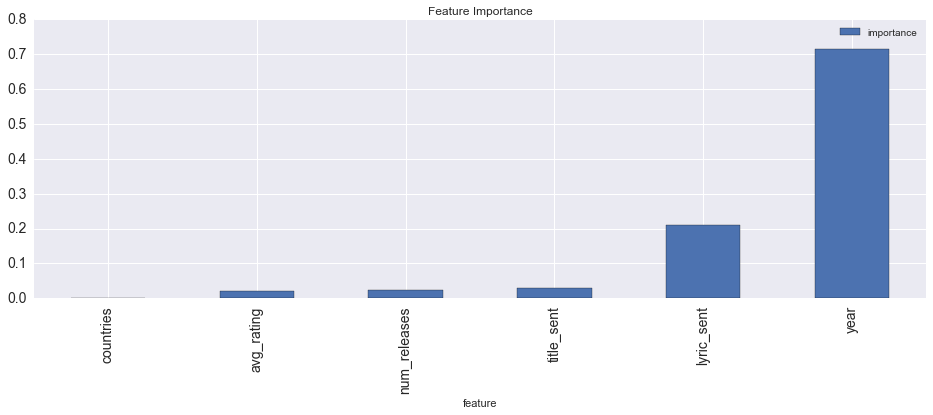

In [243]:
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_}).sort_values('importance').plot(kind='bar',x='feature',figsize=(16,5),fontsize='14',title="Feature Importance")

## While year may be important, I feel the weight of it is skewed by the results indicating the vast majority of the Beatles catalog has been covered, and well distributed across all years represented.

## Let's review some simples metrics comparing the two bands.

## A quick measure of songs covered by release year for both artists.
<br> While The Beatle disbanded by 1970, The Stones continue to this day. However, their early work appears far more influential, with the greatest body of influence more or less paralelling that of The more covered Beatles. Let's put a number on that, shall we?

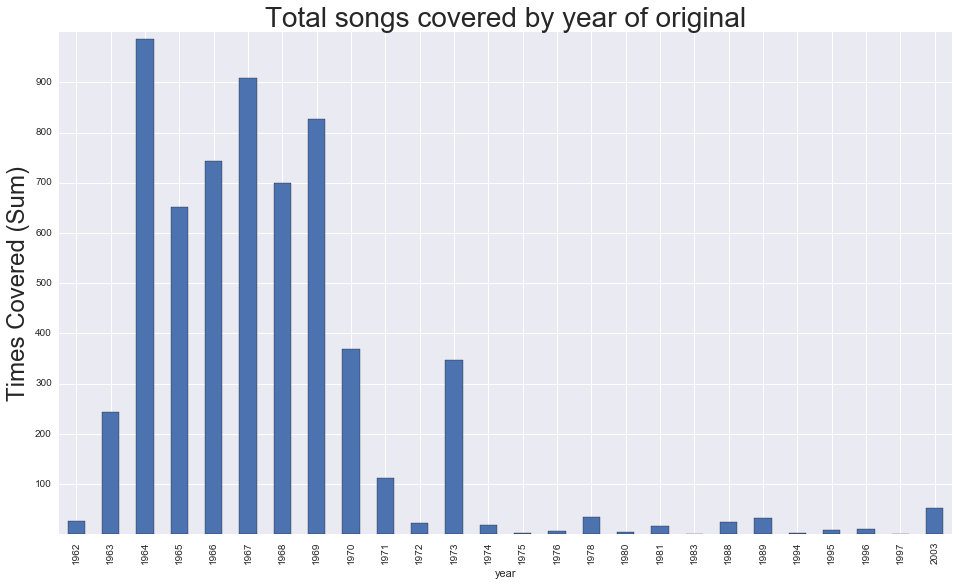

In [244]:
yticks = np.arange(100, 1000, 100)
data[data.times_covered > 0].groupby('year').times_covered.sum().plot(kind='bar',x='year',y='times_covered',figsize=(16,9))
plt.yticks(yticks)
plt.title('Total songs covered by year of original',size =28)
plt.ylabel('Times Covered (Sum)', size = 24)


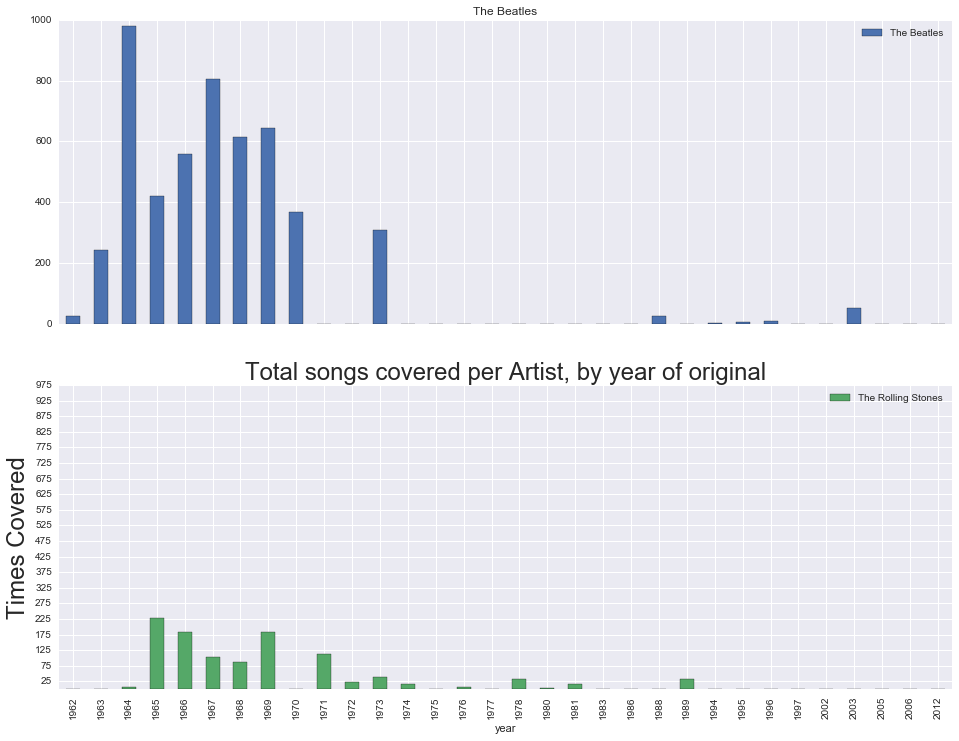

In [13]:
### First plot is The Beatles, second The Rolling Stones. Sum of times_covered by year of oriiginal relase of the song.
bar = data.sort_values(by='year').groupby(['year', 'artist'])['times_covered'].sum().unstack('artist')
yticks = np.arange(25, 1000, 50)
bar.plot(kind='bar', stacked=True,figsize=(16,12),subplots='True')
plt.yticks(yticks)
plt.title('Total songs covered per Artist, by year of original',size =24)
plt.ylabel('Times Covered', size = 24)

## It appears that a pretty large percentage of the artist's catalogs have been covered at least once.<br>
### **90%** of Beatles songs have been covered, **66%** of Rolling Stones. By this measure, The Liverpuddlians may be deemed "more influential".

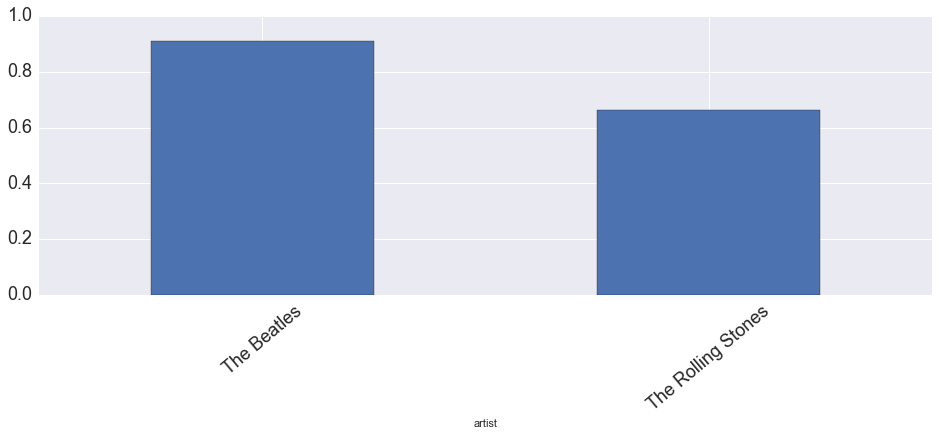

In [246]:
# Throw out covers recorded by each band and see what percentage of their catalogs have been covered.
inf = data[(data.is_cover == 0) & (data.is_covered == 1)].groupby('artist').workid.count()/data[(data.is_cover == 0)].groupby('artist').workid.count()
inf.plot(kind='bar', figsize=(16,5),fontsize=18,rot=40)

In [191]:
# Create new DataFrame with Top 10 most covered songs for each band.
top10 = data[(data.artistid == 1) & (data.is_cover ==0)][['artist','songname','minreleasedate', 'is_cover','times_covered']].sort_values(by='times_covered',ascending=False)[:10]
top10 = top10.append(data[(data.artistid == 0) & (data.is_cover ==0)][['artist','songname','minreleasedate', 'is_cover','times_covered']].sort_values(by='times_covered',ascending=False)[:10])

## "Top of the Pops"

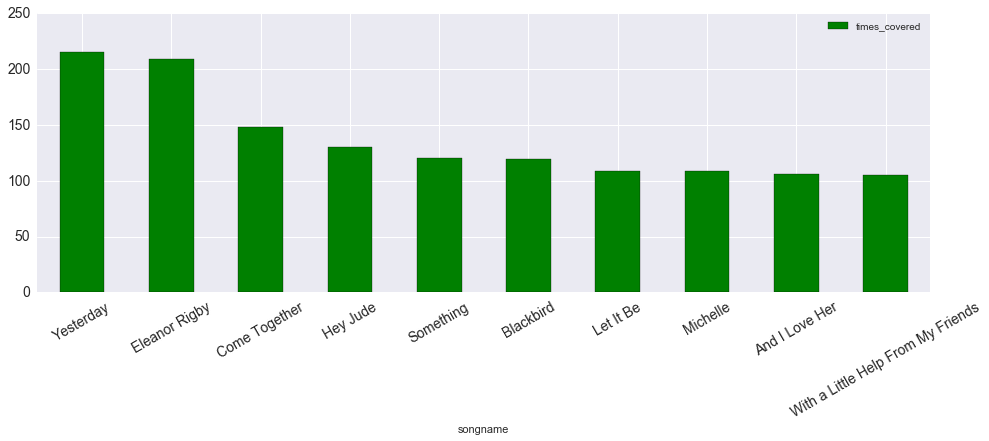

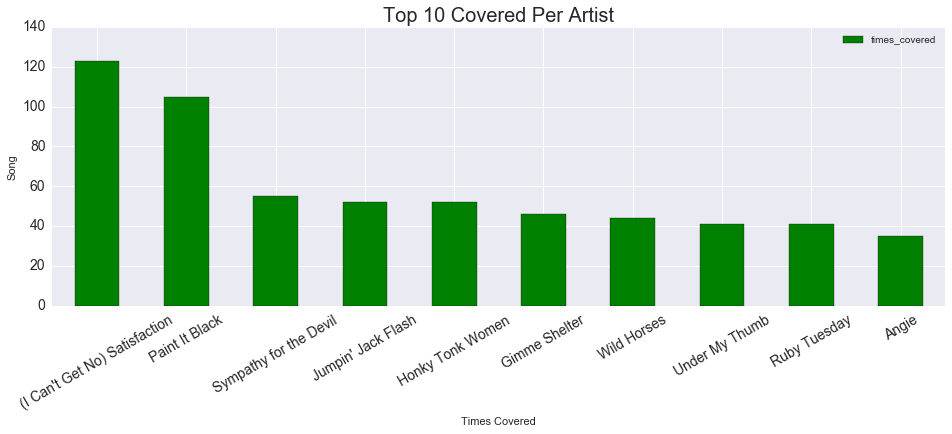

In [194]:
top10['dateint'] = top10['minreleasedate'].apply(lambda x: x.year)
colors = np.where(top10.artist == 'The Beatles', 'b', 'g')
top10.groupby('artist').plot(kind='bar', x='songname', y='times_covered',color=colors,rot=30,fontsize=14,legend=True,figsize=(16,5))
#top10.plot(kind='scatter', x='dateint', y='times_covered', s=220,c=colors, legend='artist',figsize=(12,8))
plt.title('Top 10 Covered Per Artist',size=20)
plt.xlabel('Times Covered')
plt.ylabel('Song')

In [247]:
print top10.groupby('artist').times_covered.mean()

artist
The Beatles           137.0
The Rolling Stones     59.4
Name: times_covered, dtype: float64


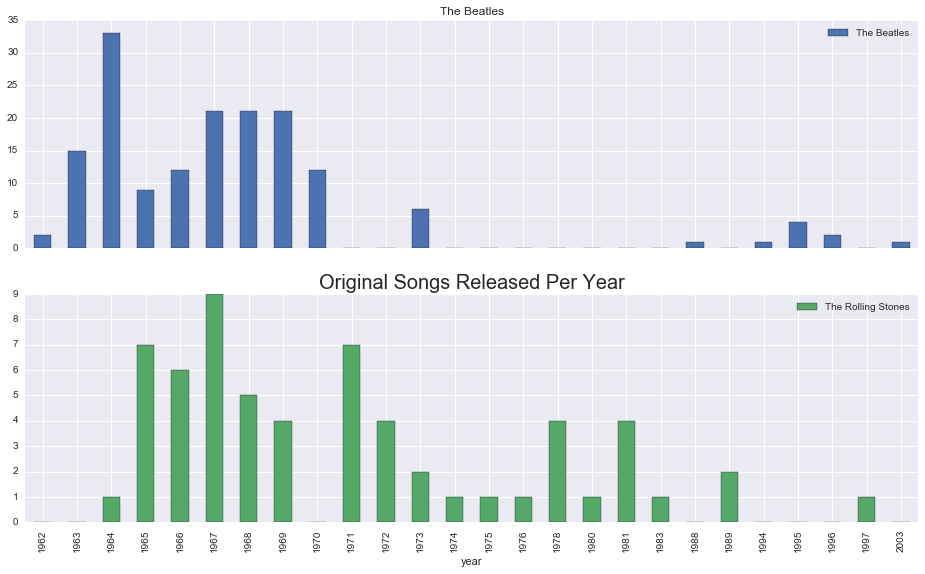

In [15]:
data[data.is_covered > 0].groupby(['artist', 'year']).songname.count().unstack('artist').plot(kind='bar',subplots='True',figsize=(16,9))
plt.title("Original Songs Released Per Year", size=20)

## Plot times covered by year.

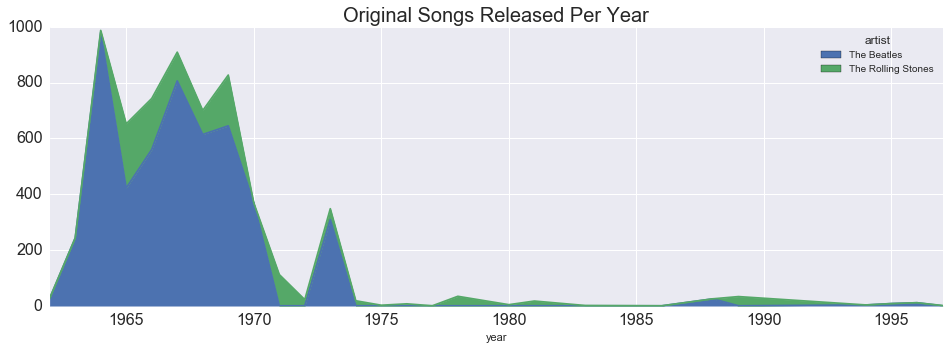

In [204]:
bar2 = data[data.year < 2000].sort_values(by='year',ascending='True').groupby(['year', 'artist'])['times_covered'].sum().unstack('artist')
bar2.plot(kind='area',figsize=(16,5),fontsize=16)
plt.title("Original Songs Released Per Year", size=20)

## The Beatles catalog essentialy ends in 1970 when they disbanded (the outliers are most likely bad release dates in my data). The Rolling Stones continue into this century. However, their years of greatest influence are similar, spanning the first 8 years of releases.<br><br>

## Test Logistic Regression Model

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

In [18]:
# Compute Null accuracy
y_null = np.zeros_like(y_test, dtype=float)
# fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null
np.sqrt(metrics.mean_squared_error(y_test, y_null))

0.36823482428085047

### Null Accuracy result is *37%*. 
#### As we will see below, when we fit the Logistic Regression estimator with our data and compute a cross validation score we improve significantly over the null test result.

In [19]:
logreg = LogisticRegression(C=1e9)
#solver='newton-cg',multi_class='multinomial',max_iter=100
logreg.fit(X_train, y_train)
zip(feature_cols, logreg.coef_[0])

[('year', -6.00176939197862e-05),
 ('num_releases', -0.12490383180456067),
 ('lyric_sent', 2.6363935941680432),
 ('title_sent', -1.0990470630763087),
 ('countries', 0.7737027649489393),
 ('avg_rating', -0.021820203303004219)]

In [20]:
print cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean()

0.866157916158


In [21]:
y_pred_prob = logreg.predict_proba(X_test)[:,1 ]
print(y_pred_prob).mean()

0.805913171628


### I am able to predict with 80% probability that a song _will be_ covered.<br><br>

### Compute ROC curve and AUC score.

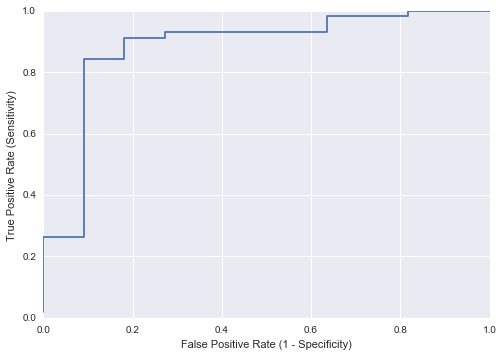

In [22]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [23]:
# calculate AUC
print metrics.roc_auc_score(y_test, y_pred_prob)
print cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.881977671451
0.797994071146


## Lyric Sentiment by Artist

OrderedDict([(u'The Beatles',
              <matplotlib.axes._subplots.AxesSubplot at 0x13a0a0850>),
             (u'The Rolling Stones',
              <matplotlib.axes._subplots.AxesSubplot at 0x139d5bc50>)])

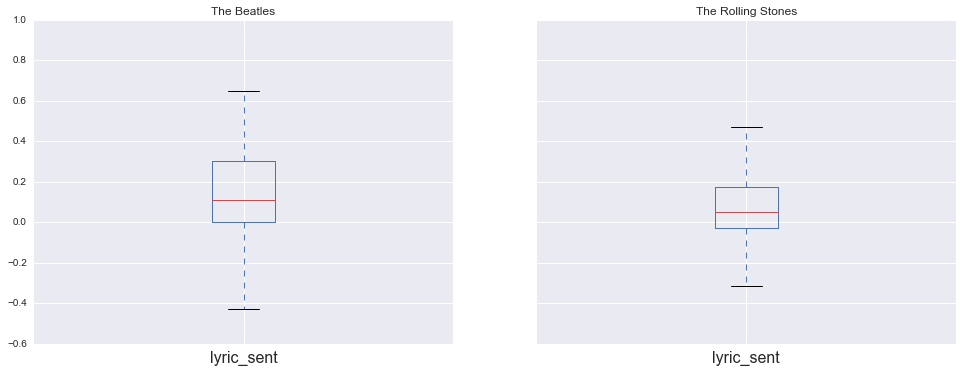

In [248]:
data[['artist','lyric_sent']].groupby('artist').boxplot(return_type='axes',figsize=(16,6),fontsize=16)

## Where to go?
## Clean up the queries for the raw data, and try to measure impact based on the trajectory of the artist's career.
## With the models trained on these two artists, could additional artist's data be pulled in to predict influence?
## Would data from an artist representing a shorter timespan acheive the same predictive value? 3 years or 5 years?